In [1]:
import sys
sys.path.append("/auto/homes/fav25/jax/")

import jax.numpy as np
# import autograd.numpy
# import numpy as np

from SC_IPFP.sde_solvers import solve_sde_RK
from SC_IPFP.utils import log_kde_pdf_per_point, silvermans_rule

from jax.config import config
from jax import jit, grad, random
from jax.experimental import optimizers
from jax.experimental import stax
from jax.experimental.stax import Dense, Relu, LogSoftmax, Sigmoid, Tanh
import numpy.random as npr
import jax
from tqdm.notebook import tqdm



import itertools
from functools import partial
# np = jax.numpy
import matplotlib.pyplot as plt
# np = autograd.numpy

/auto/homes/fav25/jax/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [221]:
X = np.arange(500).reshape(50, 10) * 1.0

theta = np.eye(10,10) * 1.0

def f(theta, X):
    out = X.dot(theta)
    return out

def divergence(f, theta_, X_):

    def my_div(f_):
        jac = jax.jacrev(f_, 1)
        return lambda t, x_: np.trace(jac(t, x_))

    div  = ((jax.vmap(my_div(f), in_axes=(None, 0)) (theta_, X_ )))
    return div
    
print(divergence(f, theta, X).shape)

(50,)


In [248]:
class cIPFP(object):
    
    def __init__(self, X_0, X_1, weights=[100], batch_size=None,  rng = jax.random.PRNGKey(0), 
                nrng = npr.RandomState(0), number_time_steps=16, sde_solver=solve_sde_RK, sigma_sq=1, 
                step_size = 0.001, num_epochs = 10, momentum_mass = 0.9, create_network=None):
        
        self.sde_solver = sde_solver
        
        self.number_time_steps = number_time_steps
        self.dt = 1.0 / number_time_steps
        
        
        self.batch_size_f = X_0.shape[0] if batch_size is None else batch_size
        self.batch_size_b = X_1.shape[0] if batch_size is None else batch_size
        
        
        self.X_0 = X_0
        self.X_1 = X_1
        
        self.H_0 = silvermans_rule(X_0)
        self.H_1 = silvermans_rule(X_1)
        
        _, self.dim = self.X_0.shape
        
        create_net = self.create_network if  create_network is None else create_network
        
        self.b_forward_init, self.b_forward = create_net(
            self.dim, weights
        )
        self.b_backward_init, self.b_backward = create_net(
            self.dim, weights
        )
        
        self.sigma = (lambda X,t: sigma_sq)
        
        self.rng = rng
        self.nrng = nrng
        
        self.opt_init_f, self.opt_update_f, self.get_params_f = (
            optimizers.adam(step_size) #, mass=momentum_mass)
        )
        
        self.opt_init_b, self.opt_update_b, self.get_params_b = (
            optimizers.adam(step_size) #, mass=momentum_mass)
        )
        
        num_complete_batches_f, leftover_f = divmod(self.X_0.shape[0], self.batch_size_f)
        self.num_batches_f = num_complete_batches_f + bool(leftover_f)
                                               
        num_complete_batches_b, leftover_b = divmod(self.X_1.shape[0], self.batch_size_b)
        self.num_batches_b = num_complete_batches_b + bool(leftover_b)
        
        self.theta_f = None
        self.theta_b = None
        
        self.b_backward_ = jax.vmap(self.b_backward, in_axes=(None, 0))
        self.b_forward_ = jax.vmap(self.b_forward, in_axes=(None, 0))
        
        self.b_backward_s =  lambda theta, x: np.squeeze(self.b_backward(x, theta))
        self.b_forward_s = lambda theta, x: np.squeeze(self.b_forward(x, theta))
        
        self.div_backward_ = jax.vmap(partial(self.divergence, self.b_backward), in_axes=(None, 0))
        self.div_forward_ = jax.vmap(partial(self.divergence, self.b_forward), in_axes=(None, 0))
#         self.div_backward_ = partial(divergence, self.b_backward)
        
    @staticmethod
    def divergence(f, theta_, X_):

        def my_div(f_):
            jac = jax.jacrev(f_, 1)
            return lambda t, x_: np.trace(jac(t, x_))

        div  = ((jax.vmap(my_div(f), in_axes=(None, 0)) (theta_, X_ )))
        return div
    
    @staticmethod
    def create_network(dim, weights):
        
        model  = []
        for weight in weights:
            model.append(
                Dense(weight)
            )
                        
            model.append(
                Relu
            )
            
        
        model.append(Dense(dim))
    
        init_random_params, predict = stax.serial(
           *model
        )
        return init_random_params, predict
    
    def data_stream(self, forward=True):
        rng = self.nrng
        X = self.X_0 if forward else self.X_1
        
        batch_size = self.batch_size_f if forward else self.batch_size_b
        num_batches = self.num_batches_f if forward else self.num_batches_b
        
        num_train = self.X_0.shape[0] if forward else self.X_1.shape[0]
        while True:
            perm = rng.permutation(num_train)
            for i in range(num_batches):
                batch_idx = perm[i * batch_size:(i + 1) * batch_size]
                yield X[batch_idx] 
        
#     @partial(jit, static_argnums=(0,3))
    def loss_for_trajectory(self, Xt, theta, W, forwards):
        n_, *_ = Xt.shape
        
        if not forwards : Xt = Xt[: , ::-1, :]
        
        
        
        if forwards:
            b_minus  = self.b_backward_(self.theta_b, Xt)
            b_plus = self.b_forward_(theta, Xt)
            div = self.div_backward_(self.theta_b, Xt)
        else:
            b_minus  = self.b_backward_(theta, Xt)
            b_plus = self.b_forward_(self.theta_f, Xt)
            div = -self.div_forward_(self.theta_f, Xt)
        
        sign = 1.0 if forwards else -1.0
        
        time_integral = (sign *  (b_plus - b_minus))**2 * self.dt 
        print(div.shape, Xt.shape , b_plus.shape)
        out =  0.5 * time_integral.sum(axis=(1,2)) - div.sum(axis=(1))
        
        if np.isnan(out).any() or np.isinf(out).any():
            import pdb; pdb.set_trace()
        return out

#     @partial(jit, static_argnums=(0,6,7,8,9,10,11))
    def inner_loss_jit(self, theta, batch,  
                       batch_terminal_empirical,
                       H,  forwards):
        
        b = (
            self.b_forward if forwards else (lambda X, theta: -self.b_backward(X, theta))
        )
        
        t, Xt, *W = self.sde_solver(
            alfa=b, beta=self.sigma, dt=self.dt, X0=batch,
            N= self.number_time_steps, theta=theta
        )
        
        cross_entropy = -log_kde_pdf_per_point(Xt[:,-1,:], batch_terminal_empirical, H)
        main_term = self.loss_for_trajectory(Xt, theta, W, forwards)
        
        if np.isnan(cross_entropy).any() or np.isnan(main_term).any():
            import pdb; pdb.set_trace()

        J = np.mean(main_term + cross_entropy )
        J = np.squeeze(J)
        return J
    
    def inner_loss(self, theta, batch, forwards=True):
                       
        batch_terminal_empirical = next(self.data_stream(forward=not(forwards)))
    
        H = self.H_1 if forwards else self.H_0
        return self.inner_loss_jit(
            theta, batch,
            batch_terminal_empirical, H ,  forwards
        )

#     @partial(jit, static_argnums=(0,1, 4))
    def update(self, i, opt_state, batch, forwards=True):

        get_params = self.get_params_f if forwards else self.get_params_b
        params = get_params(opt_state)
        
        gradient = grad(self.inner_loss)(params, batch, forwards)
    
        opt_update  = self.opt_update_f if forwards else self.opt_update_b
        return opt_update(i, gradient, opt_state)

    def fit(self, IPFP_iterations=10, sub_iterations=10):     
        
        _, init_params_f = self.b_forward_init(self.rng, (-1, self.dim))                                             
        opt_state_f = self.opt_init_f(init_params_f)
        
        _, init_params_b = self.b_backward_init(self.rng, (-1, self.dim))                                               
        opt_state_b = self.opt_init_b(init_params_b)
        
        batches_f = self.data_stream(forward=True)
        batches_b = self.data_stream(forward=False)
        
        loss_f, loss_b = [], []
        
        self.theta_f = self.get_params_f(opt_state_f)
        self.theta_b = self.get_params_b(opt_state_b)
        
        for i in tqdm(range(IPFP_iterations)):

            itercount = itertools.count()

            for k in range(sub_iterations):
                for _ in range(self.num_batches_b):
                    batch_b =  next(batches_b)
                    opt_state_b  = self.update(
                        next(itercount), opt_state_b, batch_b, False
                    )

                params_b = self.get_params_b(opt_state_b)
                lossb = self.inner_loss(params_b, batch_b, False)
                print(f"loss b {lossb}")
            loss_b.append(lossb)

            self.theta_b = params_b

            itercount = itertools.count()

            for k in range(sub_iterations):
                for _ in range(self.num_batches_f):
                    batch_f =  next(batches_f)
                    opt_state_f = self.update(
                        next(itercount), opt_state_f, next(batches_f), True
                    )
                params_f = self.get_params_f(opt_state_f)
                lossf = self.inner_loss(params_f, batch_f, True)
                print(f"loss f {lossf}")
            loss_f.append(lossf)


            self.theta_f = params_f

            self.loss_f = loss_f
            self.loss_b = loss_b

        
        plt.plot(range(IPFP_iterations), loss_f, "g")
        plt.show()
        plt.plot(range(IPFP_iterations), loss_b, "b")
        plt.show()
    
    #     @partial(jit, static_argnums=(0,2))
    def transport_batch(self, batch_x, forwards):
        theta = self.theta_f if forwards else self.theta_b    
        b = self.b_forward if forwards else  lambda X, theta: -self.b_backward(X, theta)

        t, Xt = self.sde_solver(
            alfa=b, beta=self.sigma, dt=self.dt, 
            X0=batch_x.reshape(-1,self.dim), N=self.number_time_steps, theta=theta
        )

        return Xt[:,-1,:]
            

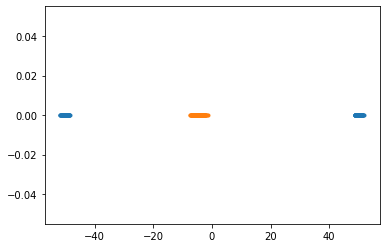

In [249]:
n = 500
n_2 = int(n * 0.5)

X1 = npr.randn(n).reshape(-1,1) - 5
X21 = 0.6 * npr.randn(n_2).reshape(-1,1) + 50
X22 =  0.6 * npr.randn(n_2).reshape(-1,1) - 50
X2 = np.concatenate((X21, X22), axis=0)

plt.plot(X2.flatten(), [0] * n, '.')
plt.plot(X1.flatten(), [0] * n, '.')

In [250]:
c = cIPFP(X1, X2,  number_time_steps=100, batch_size=500 , step_size = 0.001, weights=[500])

(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 21819.58203125
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f 3.08467698097229
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 20315.7890625
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -0.3623846471309662
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 18555.583984375
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -4.352924823760986
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 16954.935546875
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -8.718534469604492
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 15270.6455078125
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss

loss f -138.94178771972656
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 1117.97900390625
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -140.42620849609375
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 1086.4842529296875
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -141.86412048339844
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 1063.5791015625
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -143.19541931152344
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 1036.81787109375
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -144.47215270996094
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 1022.2171020507812
(500, 100) (500, 100, 1) (500, 100, 1)
(

(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -165.5496368408203
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 779.5090942382812
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -165.77662658691406
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 780.3021850585938
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -165.98910522460938
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 776.7179565429688
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -166.30569458007812
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 777.560546875
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -166.50296020507812
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500

(500, 100) (500, 100, 1) (500, 100, 1)
loss b 744.4393310546875
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -172.0982666015625
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 745.3148193359375
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -172.2076416015625
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 745.45361328125
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -172.29315185546875
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 741.2797241210938
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -172.4195556640625
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 744.0635986328125
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -172.51385498046875
(500

loss f -175.49114990234375
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 734.64013671875
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -175.56944274902344
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 734.1093139648438
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -175.64540100097656
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 731.162109375
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -175.68943786621094
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 729.8001708984375
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -175.7948455810547
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 734.1318359375
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100

(500, 100) (500, 100, 1) (500, 100, 1)
loss f -177.880859375
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 725.8617553710938
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -177.99658203125
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 724.3013305664062
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -178.02560424804688
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 724.2685546875
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -178.0691680908203
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 725.7051391601562
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -178.1419219970703
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 731.217041015625
(500, 100) (5

loss b 731.4219360351562
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -179.7957763671875
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 727.9376220703125
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -179.8624267578125
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 723.928466796875
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -179.90362548828125
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 728.4464721679688
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -179.9384002685547
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 723.3839721679688
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -179.9653778076172
(500, 100) (500, 100, 1) (500, 100, 1)
(500

(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 724.32470703125
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -181.38180541992188
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 724.0053100585938
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -181.43069458007812
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 724.730712890625
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -181.48289489746094
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 724.1087646484375
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -181.4763946533203
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 722.5347900390625
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500,

(500, 100) (500, 100, 1) (500, 100, 1)
loss f -182.7292938232422
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 721.251708984375
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -182.76031494140625
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 720.8466186523438
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -182.79586791992188
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 719.8347778320312
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -182.78140258789062
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 723.743408203125
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -182.85769653320312
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 718.5045776367188
(5

loss b 717.3396606445312
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -183.95785522460938
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 718.1305541992188
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -184.02581787109375
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 717.5252075195312
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -184.016357421875
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 717.2635498046875
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -184.06948852539062
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 720.8511962890625
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -184.0788116455078
(500, 100) (500, 100, 1) (500, 100, 1)
(5

(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 716.886962890625
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -185.1571502685547
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 720.1072387695312
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -185.17051696777344
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 715.103759765625
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -185.1840362548828
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 717.6124877929688
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -185.22650146484375
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 718.0608520507812
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500,

(500, 100) (500, 100, 1) (500, 100, 1)
loss f -186.2142333984375
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 714.4063720703125
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -186.2428741455078
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 716.6868896484375
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -186.32342529296875
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 716.438232421875
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -186.261962890625
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 717.7213745117188
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -186.29437255859375
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 718.461181640625
(500,

loss b 715.9915771484375
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -187.2384796142578
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 712.9232177734375
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -187.23123168945312
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 712.7953491210938
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -187.2771453857422
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 713.680908203125
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -187.3133087158203
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 712.72216796875
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -187.34771728515625
(500, 100) (500, 100, 1) (500, 100, 1)
(500,

(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 715.009521484375
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -188.1985321044922
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 714.298828125
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -188.22352600097656
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 713.343994140625
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -188.29049682617188
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 716.3746337890625
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -188.29849243164062
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 714.4358520507812
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 10

(500, 100) (500, 100, 1) (500, 100, 1)
loss f -189.1460418701172
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 716.9943237304688
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -189.17843627929688
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 712.316650390625
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -189.25506591796875
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 716.0831298828125
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -189.25106811523438
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 713.9061889648438
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -189.2958526611328
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 711.7742309570312
(5

loss b 711.0302124023438
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -190.1607208251953
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 712.7306518554688
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -190.17007446289062
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 712.959716796875
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -190.1908416748047
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 709.74560546875
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -190.25439453125
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 706.7061767578125
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -190.2335662841797
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 10

(500, 100) (500, 100, 1) (500, 100, 1)
loss b 715.5055541992188
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -191.09271240234375
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 714.0443115234375
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -191.12242126464844
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 716.5465698242188
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -191.13011169433594
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 712.2401123046875
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -191.189453125
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 709.6412353515625
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -191.14566040039062
(500

loss f -192.07455444335938
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 712.99462890625
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -192.0655059814453
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 711.530029296875
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -192.0666046142578
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 710.8589477539062
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -192.12261962890625
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 707.4105834960938
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -192.13722229003906
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 708.607177734375
(500, 100) (500, 100, 1) (500, 100, 1)
(500,

(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -192.98513793945312
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 706.039794921875
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -192.91473388671875
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 708.6201782226562
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -193.02403259277344
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 709.5443115234375
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -193.0157470703125
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 704.576904296875
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -193.09315490722656
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (5

(500, 100) (500, 100, 1) (500, 100, 1)
loss b 707.5643920898438
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -193.8750762939453
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 707.1180419921875
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -193.90309143066406
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 708.102783203125
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -193.89276123046875
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 710.6629028320312
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -193.90626525878906
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 708.0177001953125
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -193.95709228515625
(

loss f -194.77040100097656
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 704.8857421875
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -194.81141662597656
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 706.7488403320312
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -194.78009033203125
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 704.4457397460938
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -194.8395233154297
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 706.8411865234375
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -194.8568115234375
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 702.3237915039062
(500, 100) (500, 100, 1) (500, 100, 1)
(500

(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -195.71498107910156
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 706.7789916992188
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -195.74595642089844
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 703.01318359375
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -195.84153747558594
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 701.4883422851562
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -195.76058959960938
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 703.3877563476562
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -195.83340454101562
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (

(500, 100) (500, 100, 1) (500, 100, 1)
loss b 703.1057739257812
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -196.7720947265625
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 701.3273315429688
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -196.71005249023438
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 699.5004272460938
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -196.7906951904297
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 705.5189208984375
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -196.8121337890625
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 701.9595336914062
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -196.76881408691406
(5

loss f -197.6348114013672
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 701.2643432617188
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -197.64678955078125
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 696.9632568359375
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -197.74972534179688
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 695.9882202148438
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -197.70150756835938
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 696.5761108398438
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -197.7400665283203
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 698.8972778320312
(500, 100) (500, 100, 1) (500, 100, 1)
(

(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -198.68597412109375
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 704.832275390625
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -198.67001342773438
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 705.4019775390625
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -198.72952270507812
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 704.4931640625
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -198.7446746826172
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 703.62353515625
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -198.7950439453125
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 1

(500, 100) (500, 100, 1) (500, 100, 1)
loss b 694.9896240234375
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -199.7587890625
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 699.9838256835938
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -199.77247619628906
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 699.8131103515625
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -199.81394958496094
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 698.51708984375
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -199.8230743408203
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss b 694.2454833984375
(500, 100) (500, 100, 1) (500, 100, 1)
(500, 100) (500, 100, 1) (500, 100, 1)
loss f -199.83633422851562
(500, 

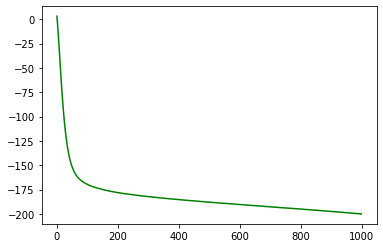

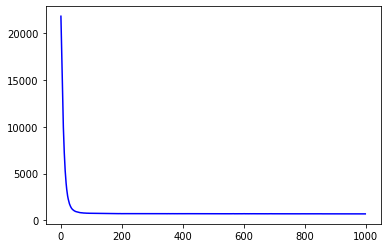

In [251]:
c.fit(1000,1)

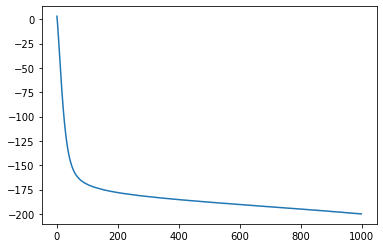

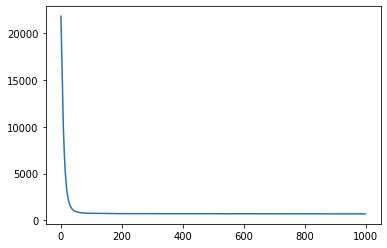

In [252]:
plt.plot(c.loss_f)
plt.show()
plt.plot(c.loss_b)

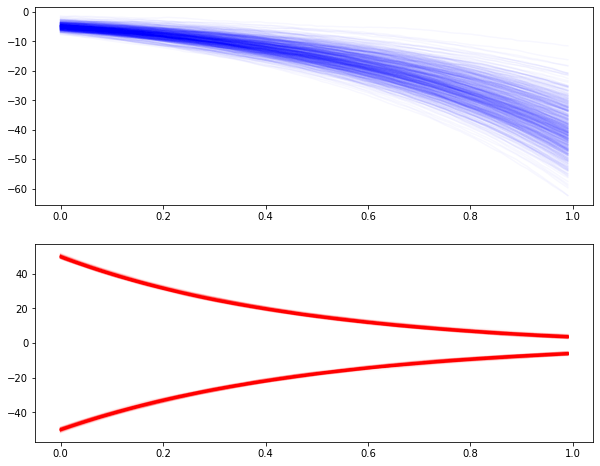

In [253]:
fig, axs = plt.subplots(2,1,  sharey=False, figsize=(10,8))


bb = lambda X, theta: -c.b_backward(X, theta)
t, Xts = c.sde_solver(X0=X1,dt=c.dt,  theta=c.theta_f,  beta=c.sigma, alfa=c.b_forward, N=c.number_time_steps)
for i in range(n):
    
    axs[0].plot(t.flatten(), Xts[i,...].flatten(), 'b', alpha=0.03, )

t_, Xts_ = c.sde_solver(X0=X2, dt=c.dt,  theta=c.theta_b,  beta=c.sigma, alfa=bb, N=c.number_time_steps)
for i in range(n):
    
    axs[1].plot(t_.flatten(), Xts_[i,...].flatten(), 'r', alpha=0.03)


In [ ]:
batch_terminal_empirical_f = next(c.data_stream(forward=True))

In [ ]:
xx = np.linspace(-10, 10).reshape(-1,1)

kd  = np.exp(log_kde_pdf_per_point(xx, batch_terminal_empirical_f, c.H_0))
plt.plot(xx, kd)
plt.plot(batch_terminal_empirical_f , [0] * len(batch_terminal_empirical_f), ".")

In [ ]:
batch_terminal_empirical_b = next(c.data_stream(False))

In [ ]:
xx = np.linspace(-10, 10).reshape(-1,1)

kd_b  = np.exp(log_kde_pdf_per_point(xx, batch_terminal_empirical_b, c.H_1))
plt.plot(xx, kd_b)
plt.plot(batch_terminal_empirical_b , [0] * len(batch_terminal_empirical_b), ".")